<a href="https://colab.research.google.com/github/abdullahalmohit/RNAseq-With-Python/blob/main/KEGG_pathway_enrichment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
res = pd.read_csv("/content/DESeq2_results_T_vs_C_annotated.csv")
res.head()

,Geneid,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Description
0,AT1G01010,2783.409773,0.904959,0.116650,7.757910,8.634049e-15,7.203149e-14,NAC001,NAC domain containing protein 1 [Source:NCBI g...
1,AT1G01020,2982.724194,0.437000,0.189795,2.302478,2.130821e-02,4.121231e-02,ARV1,ARV1 family protein [Source:NCBI gene (formerl...
2,AT1G01030,89.240373,0.408271,0.253054,1.613375,1.066631e-01,1.673376e-01,NGA3,AP2/B3-like transcriptional factor family prot...
3,AT1G01040,2262.951462,-0.587789,0.100755,-5.833864,5.415823e-09,2.826062e-08,DCL1,dicer-like 1 [Source:NCBI gene (formerly Entre...
4,AT1G01046,16.149035,-1.005451,0.571428,-1.759540,7.848588e-02,1.290246e-01,ath-MIR838,ath-MIR838 [Source:miRBase;Acc:MI0005394]


Data Preparation

In [3]:
# Choose cutoffs
padj_cutoff = 0.05
log2fc_cutoff = 1.0

# Upregulated
up_genes = res[
    (res["padj"] < padj_cutoff) &
    (res["log2FoldChange"] > log2fc_cutoff)
]["Geneid"].tolist()

# Downregulated
down_genes = res[
    (res["padj"] < padj_cutoff) &
    (res["log2FoldChange"] < -log2fc_cutoff)
]["Geneid"].tolist()

# All DEGs
deg_list = up_genes + down_genes

In [4]:
!pip install gprofiler-official

KEGG analysis

In [11]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)

kegg_res = gp.profile(
    organism="athaliana",
    query=deg_list,
    sources=["KEGG"]      # <--- this works!
)

print(kegg_res.head())

  source      native                                   name       p_value  \
0   KEGG  KEGG:01110  Biosynthesis of secondary metabolites  2.028118e-14   
1   KEGG  KEGG:00940           Phenylpropanoid biosynthesis  2.842095e-14   
2   KEGG  KEGG:01100                     Metabolic pathways  1.037336e-10   
3   KEGG  KEGG:04075      Plant hormone signal transduction  5.334134e-06   
4   KEGG  KEGG:04016         MAPK signaling pathway - plant  2.417351e-05   

   significant                            description  term_size  query_size  \
0         True  Biosynthesis of secondary metabolites       1283         880   
1         True           Phenylpropanoid biosynthesis        128         880   
2         True                     Metabolic pathways       2337         880   
3         True      Plant hormone signal transduction        291         880   
4         True         MAPK signaling pathway - plant        140         880   

   intersection_size  effective_domain_size  precision  

Visualization

In [12]:
import numpy as np

df = kegg_res.copy()
df = df[df["source"] == "KEGG"]             # keep only KEGG
df = df.sort_values("p_value")              # rank by p-value
df["-log10(p)"] = -np.log10(df["p_value"])
df = df.head(20)                            # top 20 KEGG pathways

In [17]:
import matplotlib.pyplot as plt

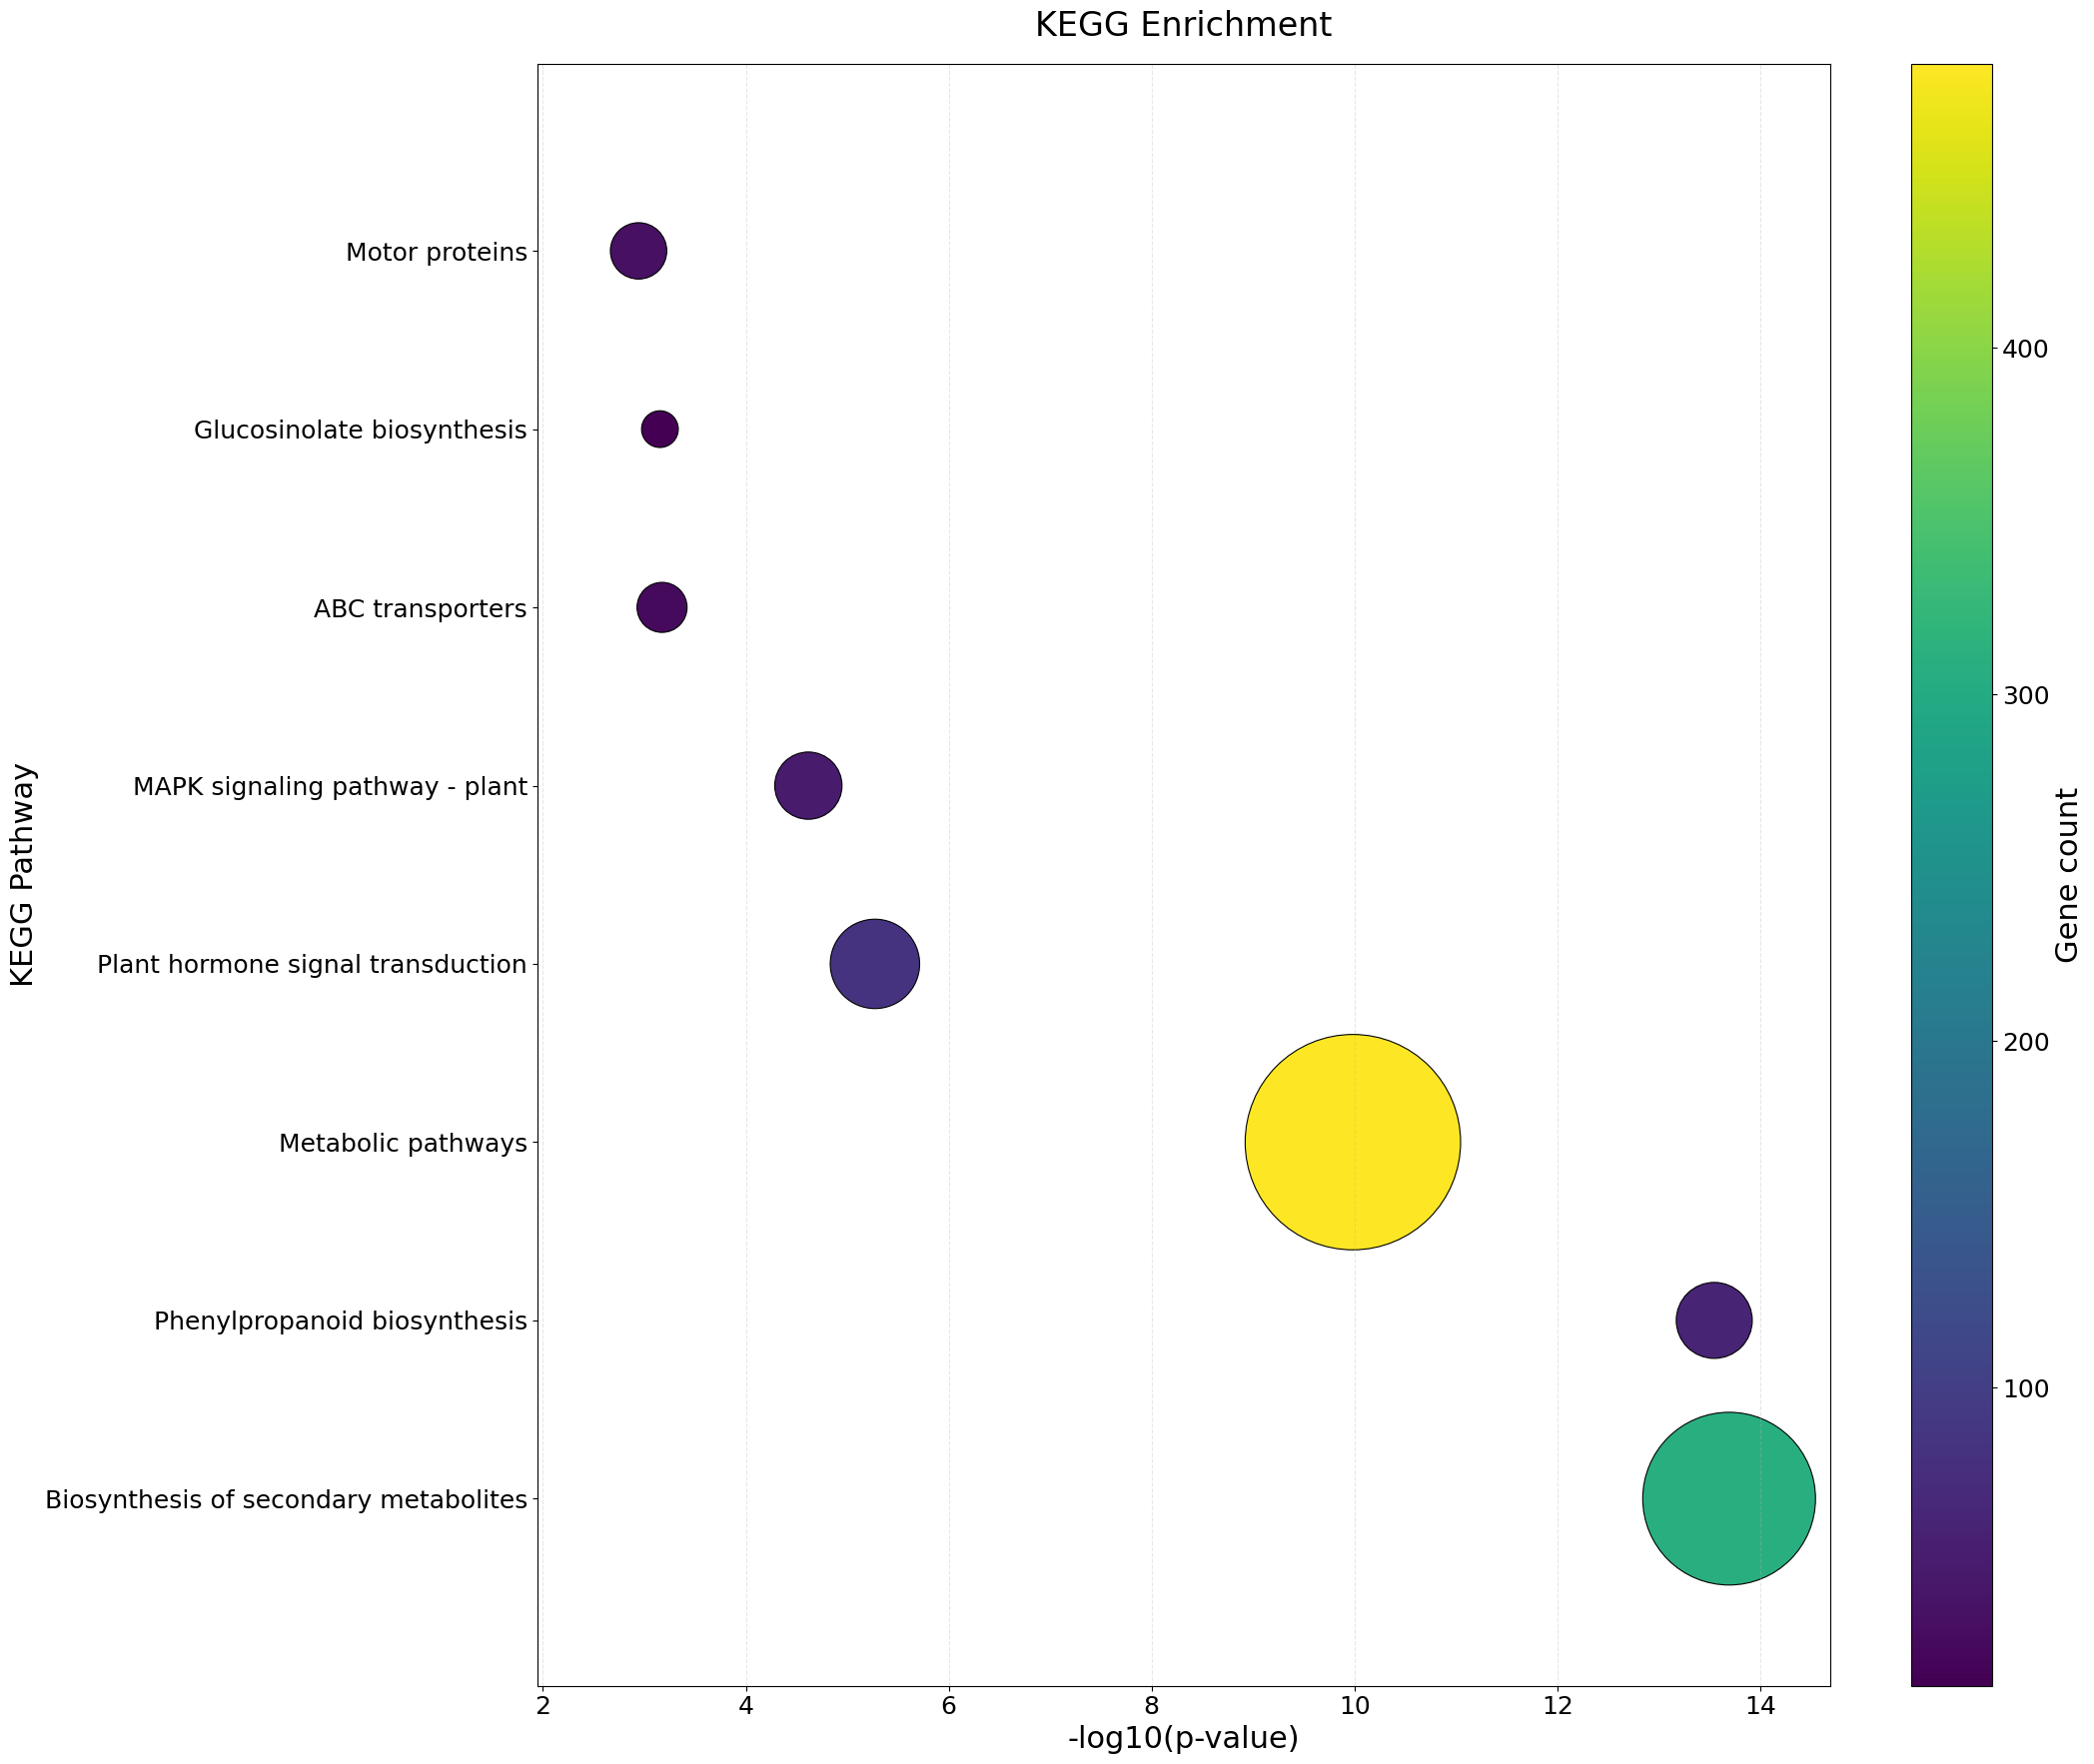

In [22]:
plt.figure(figsize=(22, 18))

# Font sizes
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 24,
    "axes.labelsize": 22,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

# Scale bubble size down to fit
bubble_scale = 50   # <-- lower value = smaller bubbles

plt.scatter(
    df["-log10(p)"],
    df["name"],
    s=df["intersection_size"] * bubble_scale,
    c=df["intersection_size"],
    cmap="viridis",
    edgecolors="black",
    linewidth=0.8
)

# Colorbar
cbar = plt.colorbar(label="Gene count")
cbar.ax.tick_params(labelsize=18)

# Labels
plt.xlabel("-log10(p-value)")
plt.ylabel("KEGG Pathway")
plt.title("KEGG Enrichment", pad=20)

# Add margins so bubbles are not cut off
plt.margins(x=0.12, y=0.15)  # increase margin to make all bubbles fit

# Alternatively force x-axis boundaries with extra padding
xmin, xmax = df["-log10(p)"].min(), df["-log10(p)"].max()
plt.xlim(xmin - 1, xmax + 1)

plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()